# Homework set 4
## Small sample bias in OLS regression with positive autocorrelation

**Author** Pierre Mabille 

**NYU ID** N10017621 

**Date** March 4, 2016 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress 
from numba import jit # Numba module for just-in-time compilation

%matplotlib inline

Define global parameters and experiment

In [2]:
alpha_vec = [.5, .6, .7, .8, .9] # list of alphas to loop through
Nrange = np.arange(50,500+50,50) # list of sample sizes to loop through

Nsim = 5000 # simulation length for Monte-Carlo estimation of OLS estimator bias

sigma = 5.0 # std. dev. normal shock
beta = 1.0 # AR(1) constant

Define a function generating the time series $(X_t)_{t=0}^n$ for given first-order autocorrelation $\alpha$ and given sample size $n$:
$$X_{t+1} = \alpha x_t + \beta + \sigma W_{t+1}$$
$$W_{t+1} \stackrel{iid}{\sim} \mathcal{N}(0,1) $$

In [5]:
def generate_series(alpha,n):
    W = np.random.normal(0,1,n+1) # draw series of normally distributed random variables
    x = np.empty(n+1)
    x[0] = W[0]
    for t in range(n):
        x[t+1] = alpha*x[t] + beta + sigma*W[t+1] 
    return x

Define a function that estimates the bias of the OLS estimator $\widehat{\alpha}$ of $\alpha$. For given $\alpha$ and $n$, the function approximates by a Monte-Carlo simulation the quantity $$ bias = \mathbb{E}\left[\widehat{\alpha} \right] - \alpha $$
It does so by drawing $N_{sim}$ series from the data generating process , each of sample size $n$, and computing the sample counterpart of $\mathbb{E}\left[\widehat{\alpha} \right]-\alpha$, namely $\frac{1}{N_{sim}} \sum_{i=1}^{N_{sim}} \widehat{\alpha}_i -\alpha$.

In [3]:
def estimate_bias(alpha,n,Nsim): # estimate bias' expectation (Monte-Carlo approx) for given alpha and sample size n 
    sum_alphahat = 0.0
#     alphahat_vec = np.empty(Nsim+1)
    for i in range(Nsim): # Monte-Carlo approximation of the expectation of the OLS estimator
        Y = generate_series_numba(alpha,n) # generate series (X_t)_t, every time new random number generator seed
        X = np.delete(Y,n) # delete last element
        Y = np.delete(Y,0) # delete first element
        alphahat, intercept, r_value, p_value, std_err = linregress(X,Y) # OLS regression 
#         alphahat_vec[i], intercept, r_value, p_value, std_err = linregress(X,Y) # OLS regression 
        sum_alphahat = sum_alphahat + alphahat
#     return np.sum(alphahat_vec)/Nsim - alpha     
    return sum_alphahat/Nsim - alpha 

The two functions defined above are optimized to allow JIT compilation (except for SciPy's linregress function, which computes the OLS estimator in the AR(1) model). This is done by using NumPy arrays whenever it is possible, which Numba treats as typed memory regions. 

In [6]:
generate_series_numba = jit(generate_series)
estimate_bias_numba = jit(estimate_bias)

Main code: this function loops over $\alpha \in \mathbf{\alpha_{vec}}$ and sample sizes $n \in \mathbf{N_{range}}$ and generates a list, which contains the estimations of the biases associated to each $n$ for a given $\alpha$, and does so for each $\alpha \in \mathbf{\alpha_{vec}}$. It also uses NumPy arrays.

In [8]:
def generate_bias(alpha_vec,Nrange,Nsim):
    bias_series = np.empty(0) # initialize container to store series of biases, for each alpha

    for alpha in alpha_vec: # loop over alphas
        # initialize array to store series of biases (depending on sample size n), given alpha in outer loop 
        bias_series_alpha = np.empty(0)   

        for n in Nrange: # loop over sample size  
            bias = estimate_bias_numba(alpha,n,Nsim) # estimate bias for given alpha and sample size n 
            bias_series_alpha = np.append(bias_series_alpha, bias)  

        bias_series = np.append(bias_series, bias_series_alpha)
        
    return bias_series

The following code generates a plot relating the OLS estimator bias $\mathbb{E}\left[\widehat{\alpha} \right] - \alpha $ (vertical axis) to the sample size $n$ (horizontal axis). It calls the main function that generates the series of biases, for each $\alpha$. It extracts the corresponding series of biases from the generated list, and plots them on the same graph. 

Overall, the OLS estimator bias of the first-order autocorrelation coefficient $\alpha$ decreases with sample size. It reflects the fact that the OLS estimator is consistent, but is downward-biased in small samples. Also, the bias is larger for larger $\alpha$, and this ranking persists as $n$ increases. Finally, the bias is also larger for larger shocks $\sigma$ (not displayed here). These results are consistent with econometric theory.

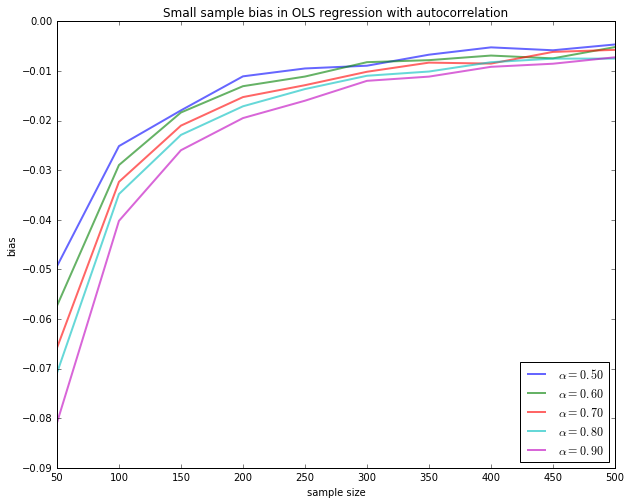

In [10]:
biases = generate_bias(alpha_vec,Nrange,Nsim)

fig, ax = plt.subplots(figsize=(10,8)) # set figure size for better display
x = Nrange
for i in range(len(alpha_vec)):
    y = biases[i*10:i*10+10]
    current_label = r'$\alpha = {0:.2f}$'.format(alpha_vec[i])
    ax.plot(x, y, linewidth=2, alpha=0.6, label=current_label)
    ax.set_title('Small sample bias in OLS regression with autocorrelation')
    ax.set_xlabel('sample size')
    ax.set_ylabel('bias')
ax.legend(loc='lower right')
plt.show()